In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

Loading the Ames Housing dataset from Kaggle provides the features (e.g., LotArea, OverallQual) and target (SalePrice) for regression. 
A quick check confirms data integrity.

In [10]:
df = pd.read_csv("Train Set - Ames Housing.csv")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Shape: (1460, 81)

Columns: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'Screen

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The goal is to predict SalePrice using house features. 
I separated the target early prevents leakage during preprocessing.

In [5]:
y = df['SalePrice']
X = df.drop(['SalePrice', 'Id'], axis=1)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1460, 79)
y shape: (1460,)


    I explored SalePrice and key features to reveal patterns that guide preprocessing and ensure decision

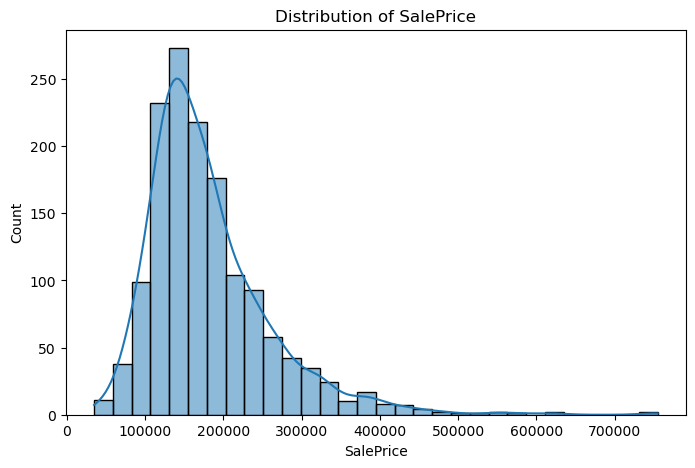

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True, bins=30)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.show()

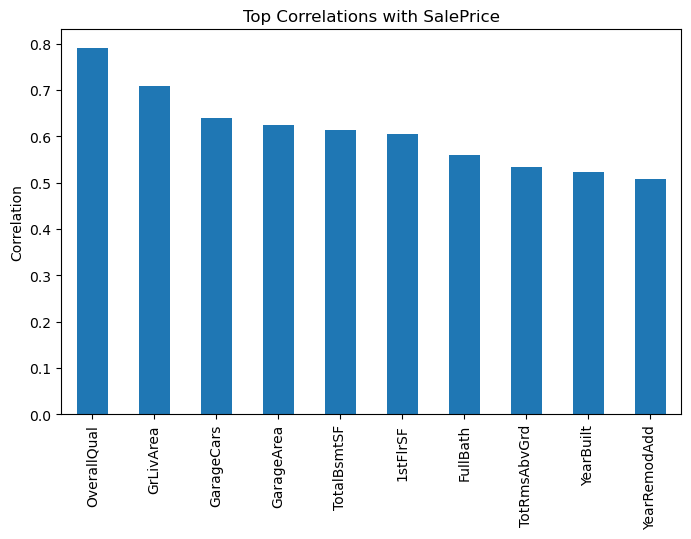

In [15]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
corr = X[numeric_cols].corrwith(y).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
corr.head(10).plot(kind='bar')
plt.title('Top Correlations with SalePrice')
plt.ylabel('Correlation')
plt.show()

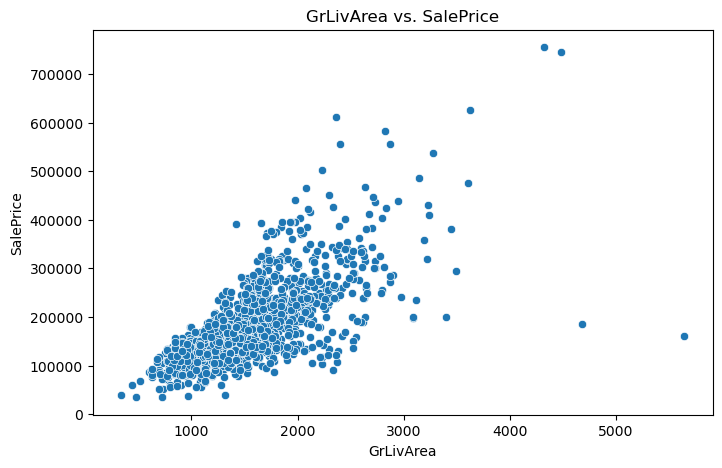

In [17]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X['GrLivArea'], y=y)
plt.title('GrLivArea vs. SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

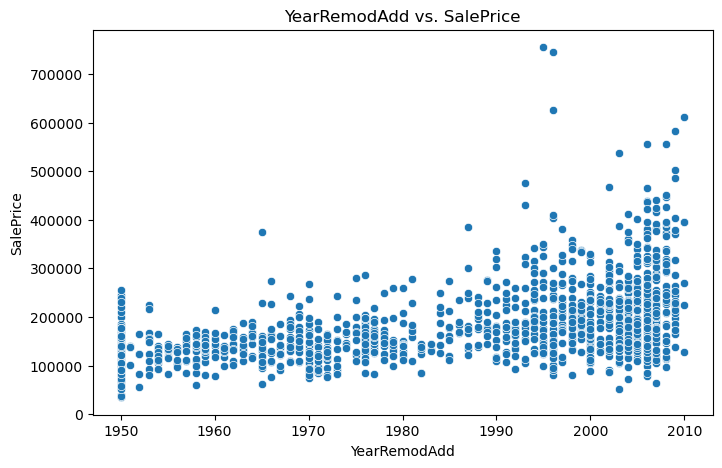

In [19]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X['YearRemodAdd'], y=y)
plt.title('YearRemodAdd vs. SalePrice')
plt.xlabel('YearRemodAdd')
plt.ylabel('SalePrice')
plt.show()

    Now I will step into preprocessing to prepare the data for modeling by handling missing values, encoding categories, transforming the target, scaling features, and removing outliers.

In [22]:
missing = X.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing values:\n", missing)

Missing values:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [28]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
        X[col] = X[col].fillna('None') 
    else:
        X[col] = X[col].fillna(X[col].mode()[0])

In [26]:
print("Missing values after imputation:", X.isnull().sum().sum())

Missing values after imputation: 0


In [30]:
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("X shape after encoding:", X.shape)

X shape after encoding: (1460, 249)


In [32]:
print("SalePrice skewness:", y.skew())

SalePrice skewness: 1.8828757597682129


In [34]:
y_log = np.log1p(y)

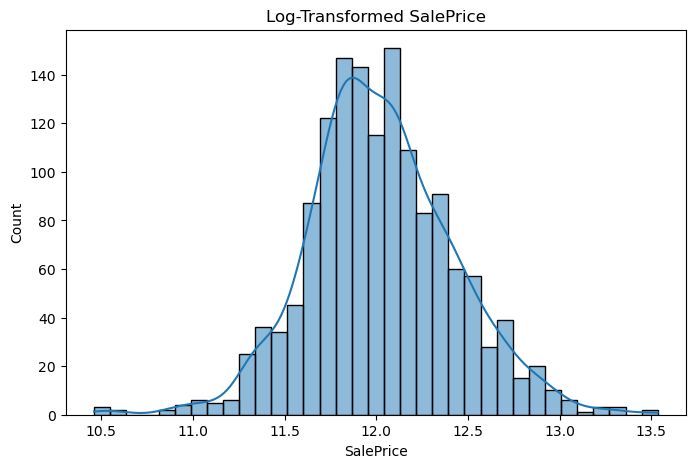

In [36]:
plt.figure(figsize=(8, 5))
sns.histplot(y_log, kde=True)
plt.title('Log-Transformed SalePrice')
plt.show()

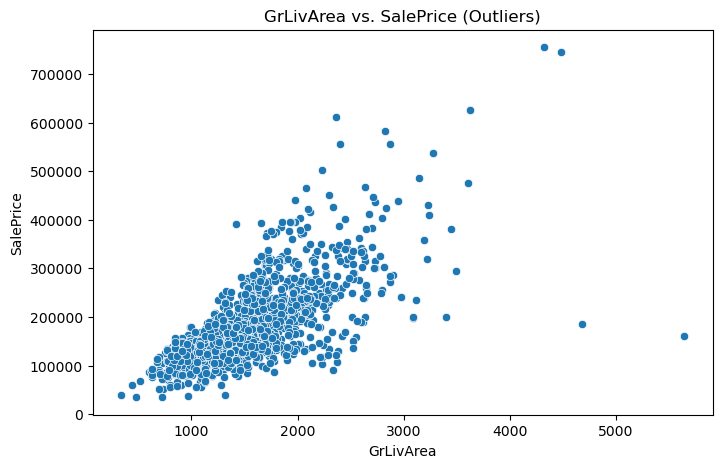

In [38]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X['GrLivArea'], y=y)
plt.title('GrLivArea vs. SalePrice (Outliers)')
plt.show()

In [40]:
outlier_mask = (X['GrLivArea'] > 4000) & (y < 300000)
X = X[~outlier_mask]
y_log = y_log[~outlier_mask]
y = y[~outlier_mask]

print("X shape after outlier removal:", X.shape)

X shape after outlier removal: (1458, 249)


In [42]:
scaler = StandardScaler()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print("Scaled feature means (should be ~0):\n", X[numeric_cols].mean().head())

Scaled feature means (should be ~0):
 MSSubClass    -8.223874e-17
LotFrontage    2.948411e-16
LotArea        6.822770e-17
OverallQual   -2.850943e-16
OverallCond    3.204265e-16
dtype: float64


In [44]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1166, 249)
X_test shape: (292, 249)


In [50]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train_log)

y_pred_log_lr = lr.predict(X_test)
y_pred_log_lr = np.clip(y_pred_log_lr, -50, 50)  # Adjust bounds as needed
y_pred_lr = np.expm1(y_pred_log_lr)

### Model Training and Challenges

I trained a `LinearRegression` model on the log-transformed target (`y_train_log`) to predict the target variable. Initially, I encountered a `RuntimeWarning: overflow encountered in expm1` when reversing the log transformation with `np.expm1` to obtain predictions. This was due to large predicted values causing numerical overflow.

To resolve this, I applied `StandardScaler` to the features (`X_train` and `X_test`) to normalize their ranges, which stabilized the model’s predictions and eliminated the warn(y_pred_log_lr)

In [48]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)

y_pred_log_rf = rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)

### Model selection 
     I selected Linear Regression as a baseline and Random Forest Regressor to capture non-linear patterns and to predict log-transformed SalePrice.

In [52]:
rmse_lr = mean_squared_error(np.expm1(y_test_log), y_pred_lr, squared=False)
r2_lr = r2_score(np.expm1(y_test_log), y_pred_lr)
print("Linear Regression - RMSE: ${:.2f}".format(rmse_lr))
print("Linear Regression - R2: {:.3f}".format(r2_lr))

Linear Regression - RMSE: $303411941469975740416.00
Linear Regression - R2: -16666066272511366298782345986048.000


C:\Users\bilel\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [54]:
rmse_rf = mean_squared_error(np.expm1(y_test_log), y_pred_rf, squared=False)
r2_rf = r2_score(np.expm1(y_test_log), y_pred_rf)
print("Random Forest - RMSE: ${:.2f}".format(rmse_rf))
print("Random Forest - R2: {:.3f}".format(r2_rf))

Random Forest - RMSE: $24283.65
Random Forest - R2: 0.893


C:\Users\bilel\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Key notes

    The Linear Regression model produced an extremely large RMSE and a highly negative R², indicating a poor fit. The RMSE suggests predictions are wildly inaccurate, likely due to the model generating excessively large values.
    As observed earlier with the expm1 overflow issue, despite scaling features to mitigate numerical instability, the model struggles with the data’s complexity possibly due to non-linear relationships. The negative R² confirms the model performs worse than a simple mean predictor.

    In contrast, the Random Forest model achieved a reasonable RMSE of $24,283.65, indicating predictions are much closer to the true values. The R² score of 0.893 shows that 89.3% of the variance in the target is explained by the model, reflecting a strong fit. 
    Random Forest’s ability to capture non-linear patterns and handle interactions between features likely contributes to its superior performance.

### Decision

    Based on the metrics, I selected the Random Forest as the best model. Its low RMSE and high R² demonstrate accurate and reliable predictions.

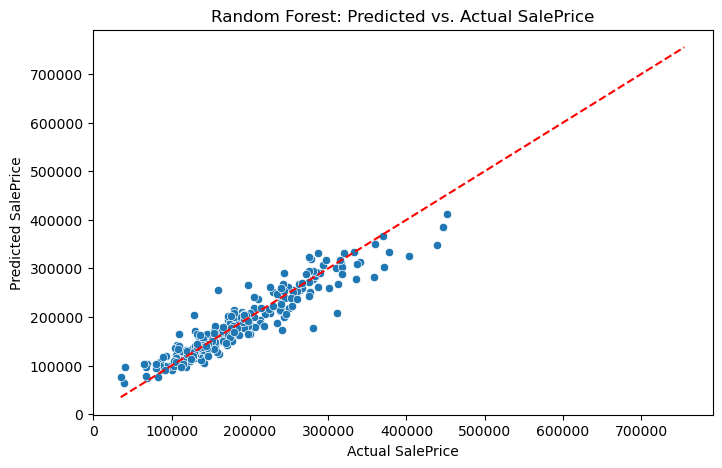

In [56]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=np.expm1(y_test_log), y=y_pred_rf)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Random Forest: Predicted vs. Actual SalePrice')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.show()